# Water Change

## This notebook is currently under development!



### Install requirements

In [1]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

### Import required modules

In [2]:
%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube.storage import masking
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.dc_utilities import write_geotiff_from_xr

import numpy as np
import xarray as xr
import dask

## Initialise

In [3]:
dc = datacube.Datacube(app='ls8-fcscene')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [4]:
#set baseline start and end of period
baseline_start_date = '2019-1-1'
baseline_end_date = '2019-8-30'

analysis_start_date = '2000-1-1'
analysis_end_date = '2000-8-30'

#resolution - have this as a variable which can be changed. 
res = (30)

# options include "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"
analysis_platform = "LANDSAT_7"
baseline_platform = "LANDSAT_8"

aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

#this is a constant across FIJI so maybe put it not as a variable but built into query. 
output_projection = "EPSG:32760"

## Translate inputs

In [5]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)


In [6]:
#create resolution
resolution = (-res, res)

In [7]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [8]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [9]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [10]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        #water_product = 's2_esa_sr_granule'
        #measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
        print('Sentinel-2 is the platform')
    elif platform in ["LANDSAT_8"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return water_product

In [11]:
baseline_water_product = create_product_measurement(baseline_platform)
analysis_water_product = create_product_measurement(analysis_platform)

## Load Data 

In [12]:
#generic for load query
query = {
    'longitude': lon_extents,
    'latitude': lat_extents,
    'output_crs': output_projection,
    'resolution': resolution,
    #'time': baseline_time_period,
    'measurements': water_measurements,
    'dask_chunks': dask_chunks
}

In [13]:
#load baseline dataset
ds_baseline = dc.load(
    platform = baseline_platform,
    product = baseline_water_product,
    time = baseline_time_period,
    **query
)

In [14]:
#load analysis dataset
ds_analysis = dc.load(
    platform = analysis_platform,
    product = analysis_water_product,
    #measurements = measurement,
    time = analysis_time_period,
    **query
)

In [15]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds_baseline): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")
if is_dataset_empty(ds_analysis): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


## Set no data  values to nan

In [16]:
#water_classes.isel(time = 4).water_classification.plot();
wc_baseline = dask.delayed(ds_baseline.where(ds_baseline >= 0))

In [17]:
wc_analysis = dask.delayed(ds_analysis.where(ds_analysis >= 0))

## Mask cloud

## Create mosaic of water mask

In [28]:
#create mosaic of water mask
wc_baseline_mean = wc_baseline.water_classification.mean(dim='time')

In [30]:
print(wc_baseline_mean)

Delayed('mean-fe20ac2a-c77d-4b19-bb53-bdb438c0829a')


In [21]:
#wc_baseline.water_classification.mean(dim = 'time').plot();

In [22]:
#fig, ax = plt.subplots(figsize=(50,50))
#ax.imshow(wc_baseline_mean)

In [23]:
#wc_analysis_mean = wc_analysis.water_classification.mean(dim='time')
#ax.imshow(wc_analysis_mean)

In [29]:
%%time
waterpres_prob = 0.3
######THIS BIT SEEMS TO BE NOT DASKABLE?????
T0_nd_water = np.isnan(wc_baseline_mean)
wc_baseline_rc_int = wc_baseline_mean.where((wc_baseline_mean < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
wc_baseline_rc = wc_baseline_rc_int.where((wc_baseline_rc_int >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [28]:
%%time
T1_nd_water = np.isnan(wc_analysis_mean)
wc_analysis_rc_int = wc_analysis_mean.where((wc_analysis_mean < waterpres_prob) | (T1_nd_water == True), 1) # fix > prob to water
wc_analysis_rc = wc_analysis_rc_int.where((wc_analysis_rc_int >= waterpres_prob) | (T1_nd_water == True), 0) # fix < prob to no water

CPU times: user 33.2 ms, sys: 0 ns, total: 33.2 ms
Wall time: 32.1 ms


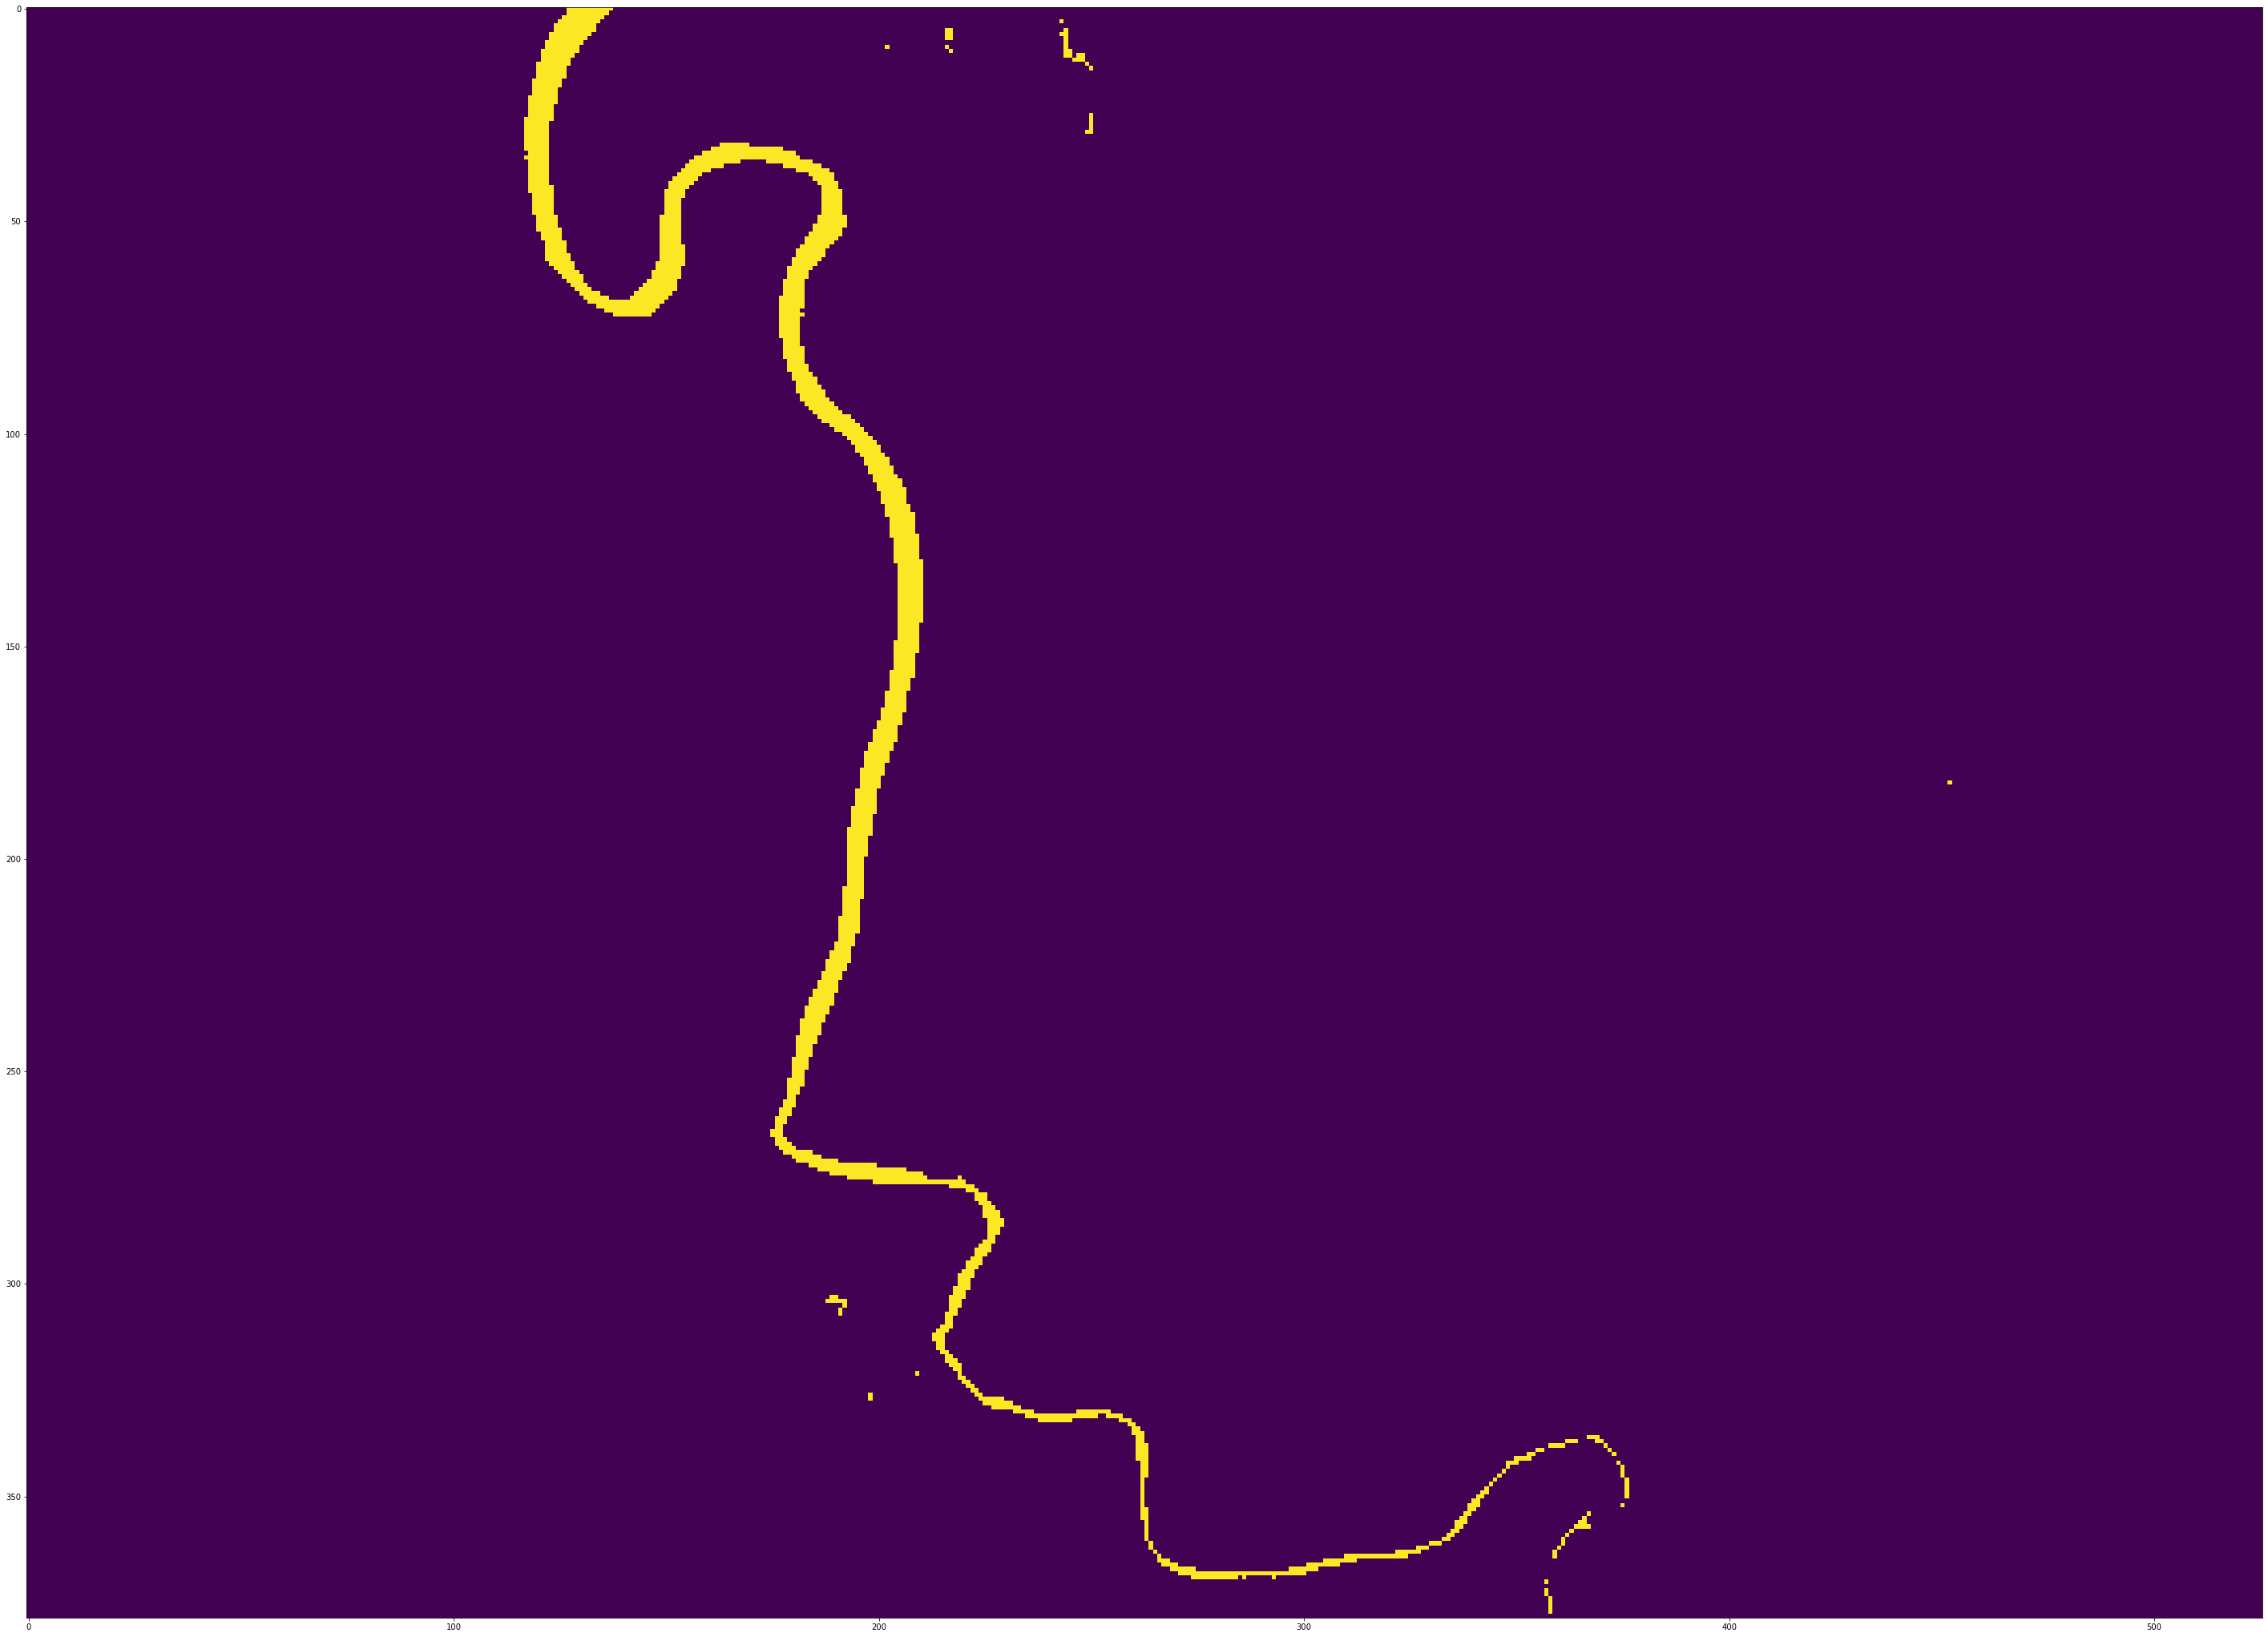

In [34]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_baseline_rc)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


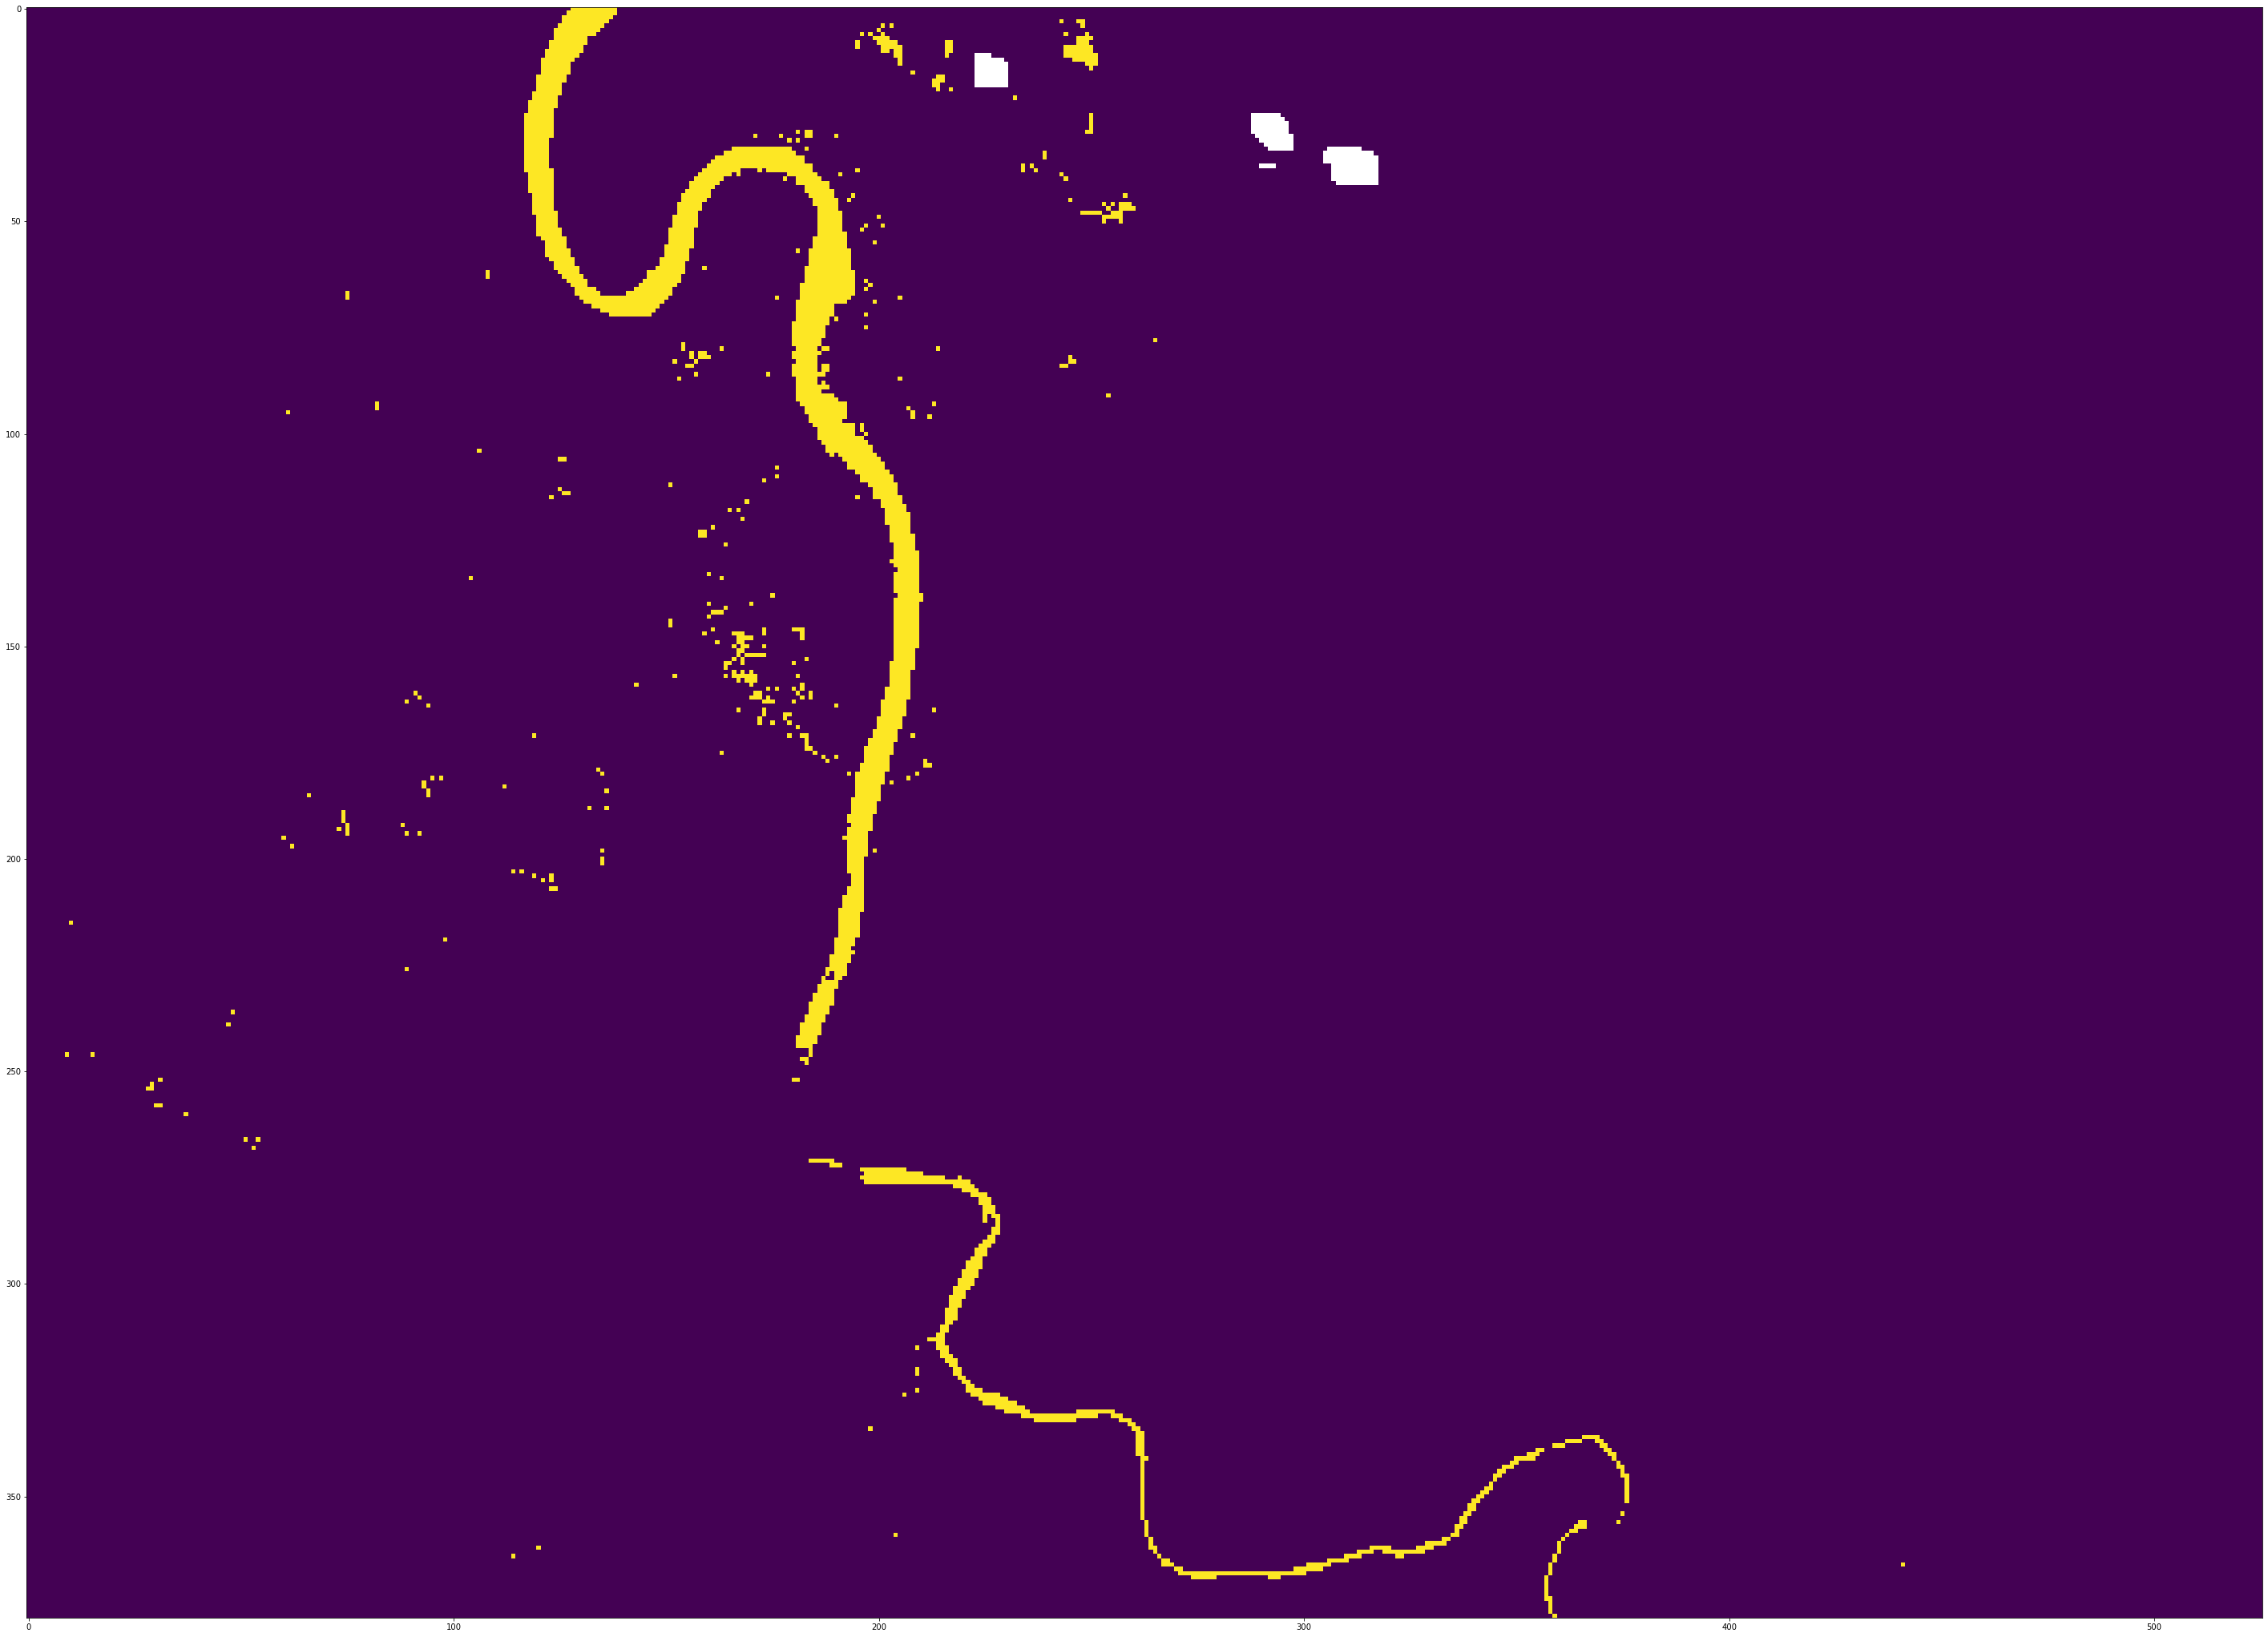

In [35]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_analysis_rc)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


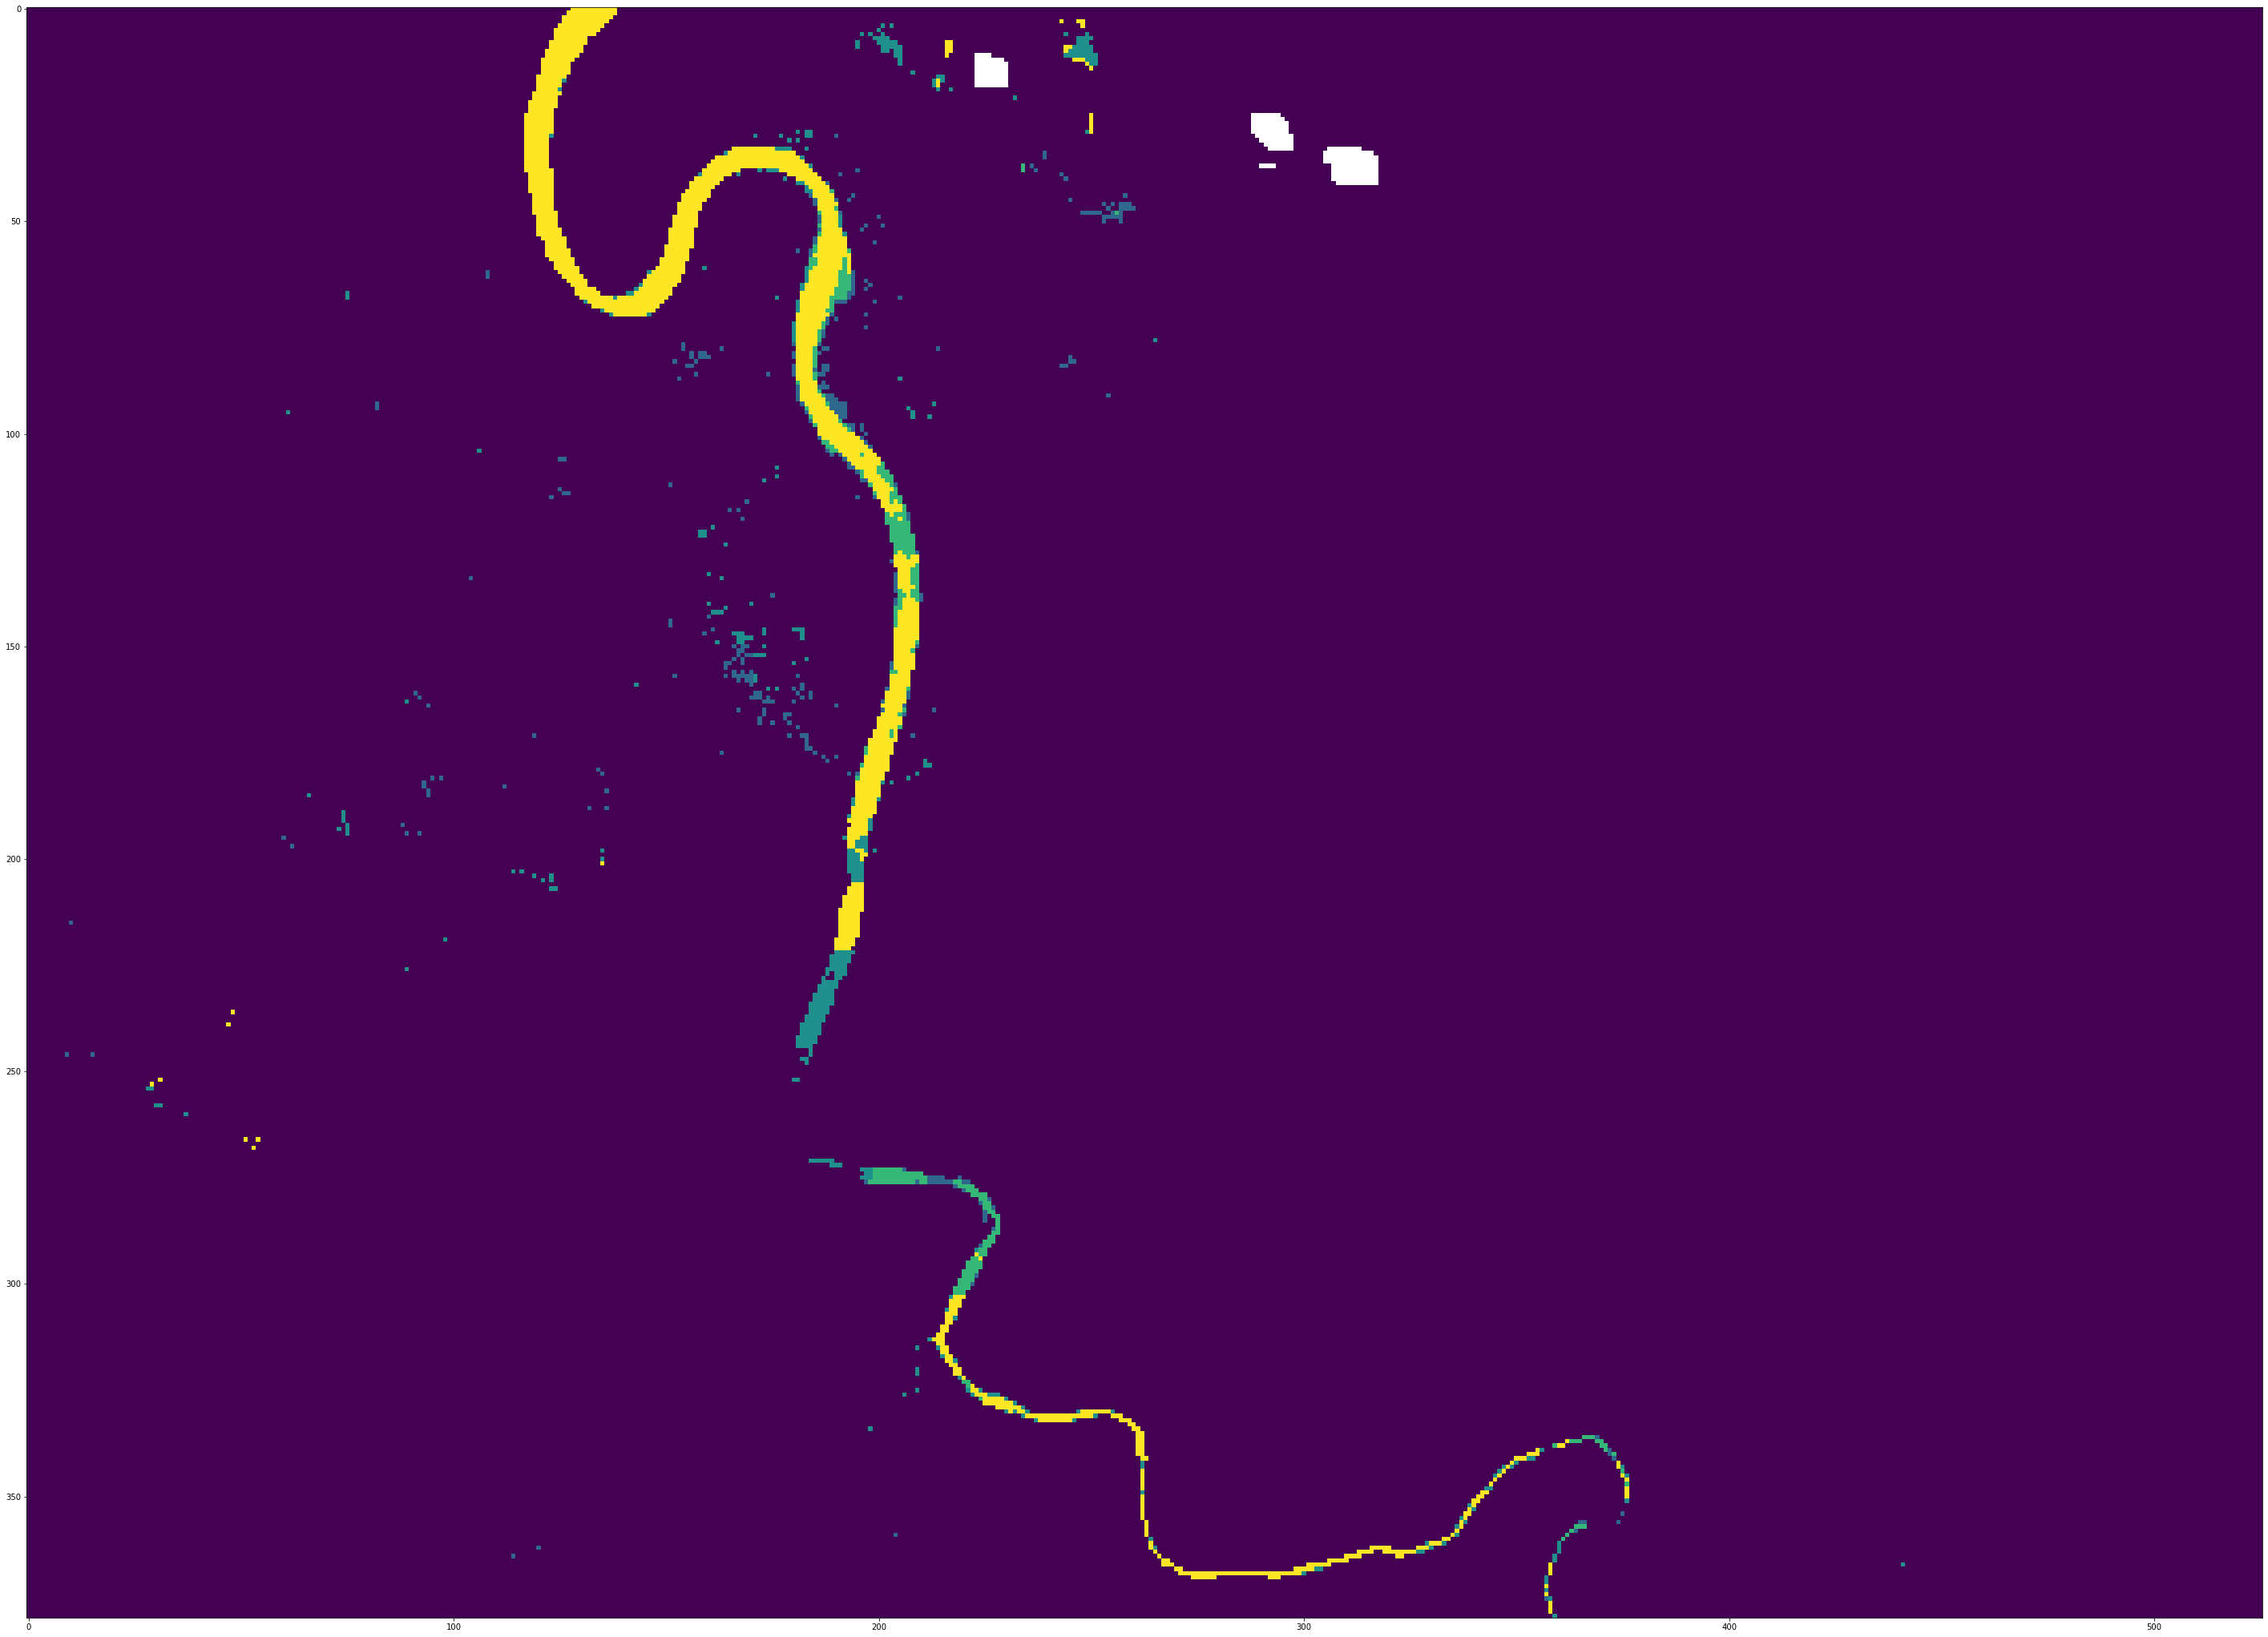

In [37]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_analysis_mean)

In [47]:
difference = (wc_analysis_rc - wc_baseline_rc)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


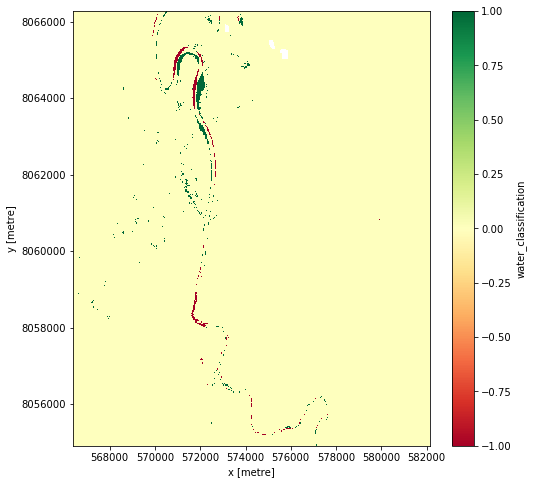

In [48]:
from matplotlib.cm import RdYlGn, Greens
plt.figure(figsize = (8,8))
difference.plot(vmin=-1, vmax=1, cmap=RdYlGn)

In [43]:
difference_range = (wc_analysis_mean - wc_baseline_mean)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


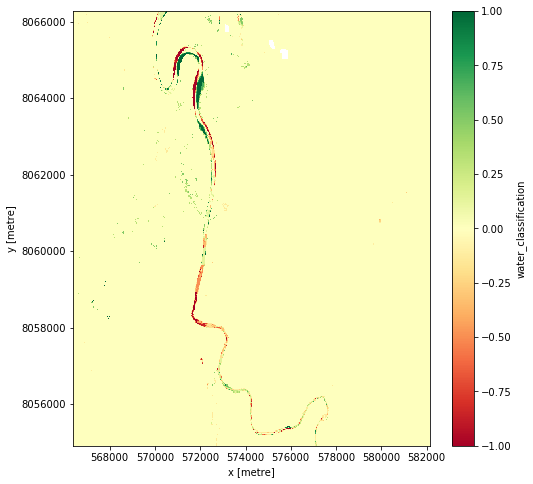

In [44]:
plt.figure(figsize = (8,8))
difference_range.plot(vmin=-1, vmax=1, cmap=RdYlGn)

In [49]:
write_geotiff_from_xr('difference_range.tiff', difference_range, crs=output_projection, x_coord = 'x', y_coord = 'y')
write_geotiff_from_xr('difference.tiff', difference, crs=output_projection, x_coord = 'x', y_coord = 'y')

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


---